In [2]:
!pip install pennylane quimb==1.8.2 > b


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

How to simulate quantum circuits with tensor networks
=====================================================

`Tensor networks </demos/tutorial_tn_circuits>`{.interpreted-text
role="doc"} are a powerful computational tool for simulating quantum
circuits. They provide a way to represent quantum states and operations
in a compact form. Unlike the state-vector approach, tensor networks are
particularly useful for large-scale simulations of [quantum
circuits](https://docs.pennylane.ai/en/stable/introduction/circuits.html).

Here, we demonstrate how to simulate quantum circuits using the
`~pennylane.devices.default_tensor.DefaultTensor`{.interpreted-text
role="class"} device in PennyLane. The used simulator is based on
[quimb](https://quimb.readthedocs.io/en/latest/), a Python library for
tensor network manipulations, and we refer to the
[documentation](https://docs.pennylane.ai/en/latest/code/api/pennylane.devices.default_tensor.DefaultTensor.html#pennylane.devices.default_tensor.DefaultTensor)
for more details. The `default.tensor` device is well-suited for
simulations of circuits with tens, hundreds, or even thousands of qubits
as long as the degree of entanglement within the circuit remains
manageable. In general, the effectiveness of this device depends on the
specific circuit structure and the provided keyword arguments. Note that
other simulators based on the state-vector approach may be more suitable
for small circuits since the overhead of tensor network contractions can
be significant.

The `default.tensor` device has just been released and is still under
development. Further improvements, new features, and additional
tutorials are expected in future releases. Check the latest
functionality in the
`documentation <.pennylane.devices.default_tensor.DefaultTensor>`{.interpreted-text
role="class"} or pick among other [PennyLane
devices](https://pennylane.ai/plugins/#built-in-devices) for your
project.

![](../_static/demonstration_assets/how_to_simulate_quantum_circuits_with_tensor_networks/TN_MPS.gif){.align-center
width="90.0%"}


Choosing the method to simulate quantum circuits
================================================

The `default.tensor` device can simulate quantum circuits using two
different computational methods. The first is the matrix product state
(MPS) representation, and the second is the full contraction approach
using a tensor network (TN). We only need to specify the `method`
keyword argument when instantiating the device to choose one or the
other. If not specified, the default method is the MPS.

The MPS method can be seen as a particular case of the TN approach,
where the tensor network has a one-dimensional structure. It can be
beneficial for obtaining approximate results, and the degree of
approximation can be controlled via the maximum bond dimension at the
expense of memory and computational cost. It is particularly useful for
simulating circuits with low entanglement.

On the other hand, the TN method always yields an exact result but can
demand higher computational and memory costs depending on the underlying
circuit structure and contraction path.


Simulating a quantum circuit with the MPS method
================================================

Let\'s start by showing how to simulate a quantum circuit using the
matrix product state (MPS) method. We consider a simple short-depth
quantum circuit that can be efficiently simulated with such a method.
The number of gates increases with the number of qubits.


In [4]:
!pip install pennylane==0.37 quimb


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pennylane as qml
import numpy as np

# Define the keyword arguments for the MPS method
kwargs_mps = {
    # Maximum bond dimension of the MPS
    "max_bond_dim": 50,
    # Cutoff parameter for the singular value decomposition
    "cutoff": np.finfo(np.complex128).eps,
    # Contraction strategy to apply gates
    "contract": "auto-mps",
}

# Parameters of the quantum circuit
theta = 0.5
phi = 0.1

# Instantiate the device with the MPS method and the specified kwargs
dev = qml.device("default.tensor", method="mps", **kwargs_mps)


# Define the quantum circuit
@qml.qnode(dev)
def circuit(theta, phi, num_qubits):
    for qubit in range(num_qubits - 4):
        qml.RX(theta, wires=qubit + 1)
        qml.CNOT(wires=[qubit, qubit + 1])
        qml.RY(phi, wires=qubit + 1)
        qml.DoubleExcitation(theta, wires=[qubit, qubit + 1, qubit + 3, qubit + 4])
        qml.Toffoli(wires=[qubit + 1, qubit + 3, qubit + 4])
    return qml.expval(
        qml.X(num_qubits - 1) @ qml.Y(num_qubits - 2) @ qml.Z(num_qubits - 3)
    )

ImportError: cannot import name 'LinearCombination' from 'pennylane.ops' (c:\Users\lclai\miniconda3\envs\house\lib\site-packages\pennylane\ops\__init__.py)

We set the maximum bond dimension to 50 and the `cutoff` parameter is
set to the machine epsilon of the `numpy.complex128` data type. For this
circuit, retaining a maximum of 50 singular values in the singular value
decomposition is more than enough to represent the quantum state
accurately. Finally, the contraction strategy is set to `auto-mps`. For
an explanation of these parameters, we refer to the
`documentation <.pennylane.devices.default_tensor.DefaultTensor>`{.interpreted-text
role="class"} of the `default.tensor` device.

As a general rule, choosing the appropriate method and setting the
optimal keyword arguments is essential to achieve the best performance
for a given quantum circuit. However, the optimal choice depends on the
specific circuit structure. For optimization tips, we also refer to the
[performance
checklist](https://quimb.readthedocs.io/en/latest/tensor-circuit.html#performance-checklist)
in the `quimb` documentation.

We can now simulate the quantum circuit for different numbers of qubits.
The execution time will generally increase as the number of qubits
grows. The first execution is typically slower due to the initial setup
and compilation processes of `quimb`.


In [4]:
import time

# Simulate the circuit for different numbers of qubits (50, 201, 50)
for num_qubits in range(10, 12, 14):
    print(f"Number of qubits: {num_qubits}")
    start_time = time.time()
    result = circuit(theta, phi, num_qubits)
    end_time = time.time()
    print(f"Result: {result}")
    print(f"Execution time: {end_time - start_time:.4f} seconds")

Number of qubits: 10
Result: 0.067650060849834
Execution time: 0.2629 seconds


Selecting the MPS method, each gate is immediately contracted into the
MPS representation of the wavefunction. Therefore, the structure of the
MPS is maintained after each gate application.

To learn more about the MPS method and its theoretical background, we
refer to the extensive literature available on the subject, such as.


Simulating a quantum circuit with the TN method
===============================================

The tensor network (TN) method is a more general approach than the
matrix product state (MPS) method. While the MPS method can be very
efficient for simulating certain quantum circuits, it may require a
large bond dimension to accurately represent highly entangled states.
This can lead to increased computational and memory costs.

For example, the full contraction scheme can be helpful in simulating
circuits with a higher degree of entanglement, although it can also face
significant computational and memory challenges.

In the following example, we consider a simple quantum circuit with a
configurable depth. As in the previous circuit, the number of gates
increases with the number of qubits.


In [31]:
import pennylane as qml
import numpy as np

# Define the keyword arguments for the TN method
kwargs_tn = {
    # Contraction strategy to apply gates
    "contract": False,
    # Simplification sequence to apply to the tensor network
    "local_simplify": "DCRS",
    # Contraction optimizer to use
    "contraction_optimizer": None,
}

# Parameters of the quantum circuit
theta = 0.5
phi = 0.1
depth = 10

# Instantiate the device with the TN method and the specified kwargs
dev = qml.device("default.tensor", method="tn", **kwargs_tn)


@qml.qnode(dev)
def circuit(theta, depth, num_qubits):
    for i in range(num_qubits):
        qml.X(wires=i)
    for _ in range(1, depth - 1):
        for i in range(0, num_qubits, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(num_qubits % 5):
            qml.RZ(theta, wires=i)
        for i in range(1, num_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
    for i in range(num_qubits):
        qml.CNOT(wires=[i, (i + 1)])
    return qml.var(qml.X(num_qubits - 1))


# Simulate the circuit for different numbers of qubits (25, 101, 25)
for num_qubits in range(3, 50, 100):
    print(f"Number of qubits: {num_qubits}")
    start_time = time.time()
    result = circuit(theta, depth, num_qubits)
    end_time = time.time()
    print(f"Result: {result}")
    print(f"Execution time: {end_time - start_time:.4f} seconds")

Number of qubits: 3
Result: 0.9999999999999973
Execution time: 0.2903 seconds


In [15]:
import pennylane as qml
import numpy as np

# Define the keyword arguments for the TN method
kwargs_tn = {
    # Contraction strategy to apply gates
    "contract": False,
    # Simplification sequence to apply to the tensor network
    "local_simplify": "DCRS",
    # Contraction optimizer to use
    "contraction_optimizer": None,
}

# Parameters of the quantum circuit
theta = 0.5
phi = 0.1
depth = 10
n_qubits = 20


# Instantiate the device with the TN method and the specified kwargs
dev1 = qml.device('default.qubit', wires=17)


@qml.qnode(dev1)
def circuit(theta, depth, num_qubits):
    for i in range(num_qubits):
        qml.X(wires=i)
    for _ in range(1, depth - 1):
        for i in range(0, num_qubits, 2):
            qml.CNOT(wires=[i, i + 1])
        for i in range(num_qubits % 5):
            qml.RZ(theta, wires=i)
        for i in range(1, num_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
    for i in range(num_qubits):
        qml.CNOT(wires=[i, (i + 1)])
    return qml.var(qml.X(num_qubits - 1))




In [28]:
# Simulate the circuit for different numbers of qubits
for num_qubits in range(3, 12, 14):
    print(f"Number of qubits: {num_qubits}")
    start_time = time.time()
    result = circuit(theta, depth, num_qubits)
    end_time = time.time()
    print(f"Result: {result}")
    print(f"Execution time: {end_time - start_time:.4f} seconds")

Number of qubits: 3
Result: 0.9999999999999974
Execution time: 0.0159 seconds


Here, we lazily add each gate to the tensor network without contracting
by setting the `contract` keyword argument to `False`. The contraction
optimizer is set to `None`, and the simplification sequence is set to
`DCRS`. As for the MPS method, we refer to the
`documentation <.pennylane.devices.default_tensor.DefaultTensor>`{.interpreted-text
role="class"} for a list and explanation of the keyword arguments
available for the TN method.

We can also visualize the tensor network representation of the quantum
circuit with the `draw` method. This method produces a graphical
representation of the tensor network using `quimb`\'s plotting
functionalities. The tensor network method usually generates a more
complex tensor network than the MPS method.

Since we did not specify the number of qubits when instantiating the
device, the number of tensors in the tensor network is inferred from the
last execution of the quantum circuit. We can visualize the tensor
network for 15 qubits.


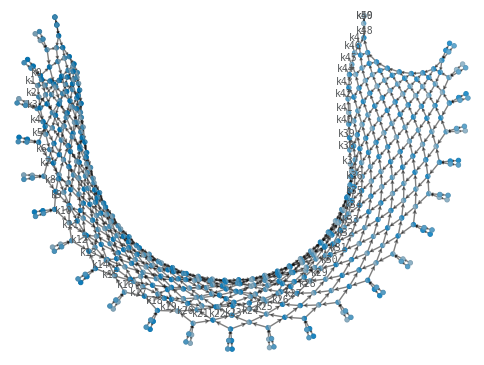

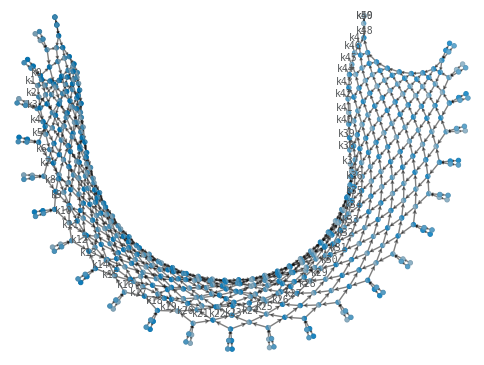

In [6]:
circuit(theta, depth, num_qubits=50)
dev.draw(color="auto", show_inds=True, return_fig=True)

References
==========


About the author
================
